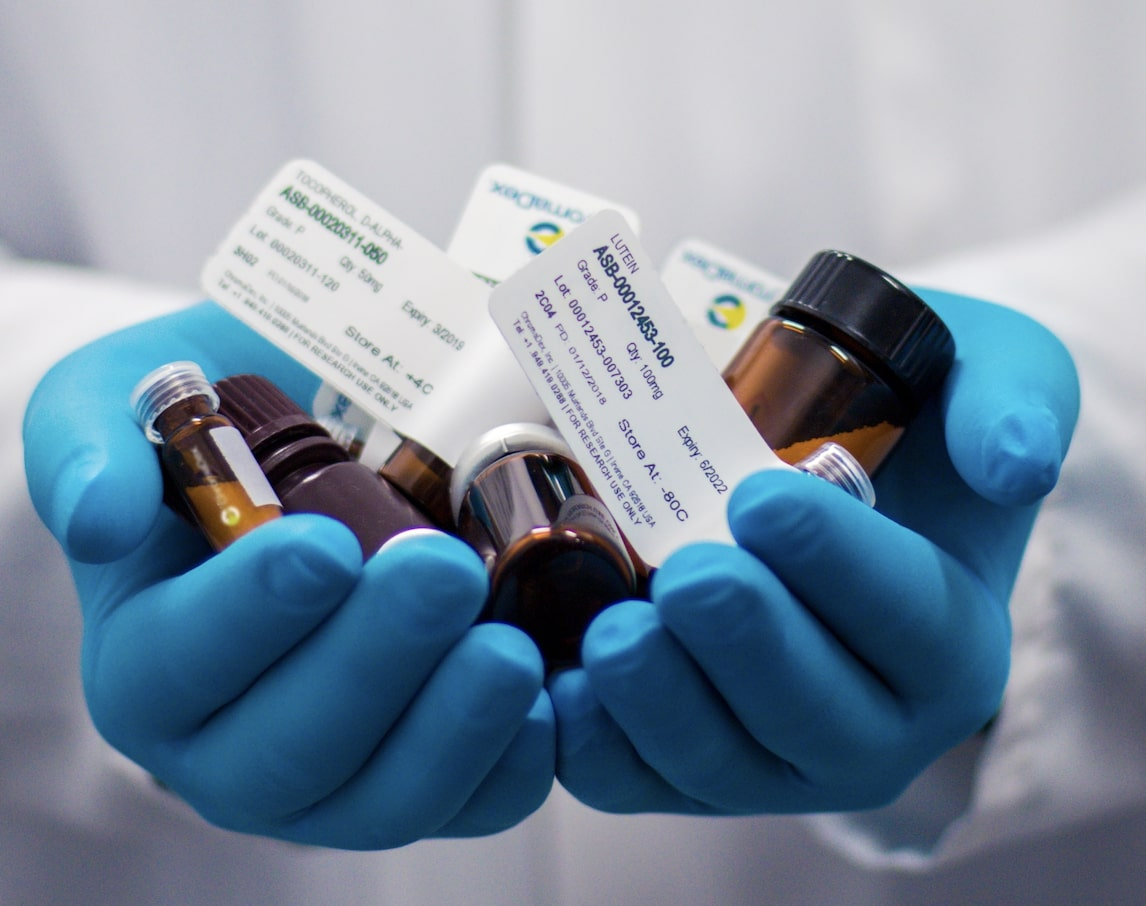

# Overview
This is a basic notebook containing fundamental EDA and data transformation for beginners. Most of the observations and transformation are generic and typical for data of this nature. I am hoping that I can save someone 30 minutes by sharing this. If you use it or find it useful, please leave a like :).

# EDA
The following observations were realized:
1. There are 3 categorical features cp_type, cp_time and cp_dose containing 2, 3 and 2 categories each. The distribution across each category is fairly even except for cp_type.
2. Distribution of prediction labels is highly imbalanced for some labels. We may use class_weights to over sample some classes however, given that data augmentation is not possible, re-sampling the same data will not yield great results. Can simply scrape some really low scoring samples.
3. Looked at min, max, median and mean values of all numerical features. They are mostly confined in the range -8 to 10 with vast majority of values (>80%) being closer to 0.
4. Looked at some sample feature distributions. The distributions looks great candidates for standard and min-max scaler.

# Transformations
Performed the following transformations:
1. Convert the categorical features to OH encoded features. Since cardinality is small for all categorical features, this works well.
2. Apply Standard and MinMaxScaler to all numerical features.

Note that if you are using these transformers, you can find the encoders during test in the following way:
1. cp_type_encoder: Encoder for cp_type categorical variable.
2. cp_time_encoder: Encoder for cp_time categorical variable.
3. cp_dose_encoder: Encoder for cp_dose categorical variable.
4. std_norm_scaler_map: Map where keys are numeric feature column names like g-0,g-1... and c-0,c-1... and the values are a tuple containing the StandardScaler and MinMaxScaler. Use it in that order only.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install iterative-stratification

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras import regularizers
from keras.models import Model

from tqdm import tqdm

In [ ]:
test_features = pd.read_csv("/kaggle/input/lish-moa/test_features.csv")
train_features = pd.read_csv("/kaggle/input/lish-moa/train_features.csv")
train_targets_scored = pd.read_csv("/kaggle/input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("/kaggle/input/lish-moa/train_targets_nonscored.csv")
sample_submission = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")

In [ ]:
# Getting glimpse of the training data
train_features.head()

In [ ]:
# Getting glimpse of the scores. 
# The structure of labelled data is slightly unconventional in this contest since it is separate out into two different dataframes, train_features and train_targets_scored
train_targets_scored.head()

In [ ]:
train_features.sort_values(by=['sig_id'], inplace=True)
train_targets_scored.sort_values(by=['sig_id'], inplace=True)

In [ ]:
# Validating each row is a unique sig_id. Usually first step in any EDA to 
print(train_features.shape)
print(train_targets_scored.shape)
print(test_features.shape)

print("All ids are unique" if train_features['sig_id'].nunique() == train_features.shape[0] else "Redundant Ids")

In [ ]:
# Looking at the distribution of categorical features
fg, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].hist(train_features.cp_type)
ax[0].set_title('cp_type')
ax[1].hist(train_features.cp_time)
ax[1].set_title('cp_time')
ax[2].hist(train_features.cp_dose)
ax[2].set_title('cp_dose')

In [ ]:
# Plotting distribution of labels
classes = sorted(train_targets_scored.sum(axis=0, numeric_only=True))
plt.plot(classes)

In [ ]:
# Look at range, mean and median of the g_col and c_col data

g_min_values = []
c_min_values = []
g_max_values = []
c_max_values = []
g_median_values = []
c_median_values = []
g_mean_values = []
c_mean_values = []

for i in range(872):
    g_col = 'g-' + str(i)
    c_col = 'c-' + str(i)
    if g_col in train_features.columns:
        g_min_values.append(train_features[g_col].min())
        g_max_values.append(train_features[g_col].max())
        g_median_values.append(train_features[g_col].median())
        g_mean_values.append(train_features[g_col].mean())
    if c_col in train_features.columns:
        c_min_values.append(train_features[c_col].min())
        c_max_values.append(train_features[c_col].max())
        c_median_values.append(train_features[c_col].median())
        c_mean_values.append(train_features[c_col].mean())
    
g_min_sorted = sorted(g_min_values)
g_max_sorted = sorted(g_max_values)
c_min_sorted = sorted(c_min_values)
c_max_sorted = sorted(c_max_values)
g_median_sorted = sorted(g_median_values)
g_mean_sorted = sorted(g_mean_values)
c_median_sorted = sorted(c_median_values)
c_mean_sorted = sorted(c_mean_values)

fg, ax = plt.subplots(2, 4, figsize=(35, 15))

ax[0,0].plot(g_min_sorted)
ax[0,0].set_title('min g_col')
ax[0,1].plot(g_max_sorted)
ax[0,1].set_title('max g_col')
ax[0,2].plot(g_median_sorted)
ax[0,2].set_title('median g_col')
ax[0,3].plot(g_mean_sorted)
ax[0,3].set_title('mean g_col')


ax[1,0].plot(c_min_sorted)
ax[1,0].set_title('min c_col')
ax[1,1].plot(c_max_sorted)
ax[1,1].set_title('max c_col')
ax[1,2].plot(c_median_sorted)
ax[1,2].set_title('median c_col')
ax[1,3].plot(c_mean_sorted)
ax[1,3].set_title('mean c_col')


In [ ]:
# Look at some sample g-col and c-col data distribution
rows = 2
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(20,8))
for row in range(rows):
    for col in range(cols):
        index = row * 2 + col
        data = sorted(train_features['g-' + str(index)])
        ax[row, col].plot(data)
        ax[row, col].set_title('g-' + str(index))


In [ ]:
# Begin Feature transformation.
# Convert the following to OHE
# cp_type
# cp_time
# cp_dose

def one_hot_encode(data, column_name):    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoded_data = encoder.fit_transform(data[column_name].values.reshape(-1, 1))
    encoded_df = pd.DataFrame(data=encoded_data, columns=train_features[column_name].unique())
    merged_data = data.merge(encoded_df, left_index=True, right_index=True)
    merged_data.drop(columns=[column_name], inplace=True)
    return encoder, merged_data

cp_type_encoder, train_features = one_hot_encode(train_features, 'cp_type')
cp_time_encoder, train_features = one_hot_encode(train_features, 'cp_time')
cp_dose_encoder, train_features = one_hot_encode(train_features, 'cp_dose')

categorical_feature_columns = []
categorical_feature_columns.extend(cp_type_encoder.categories_[0])
categorical_feature_columns.extend(cp_dose_encoder.categories_[0])
categorical_feature_columns.extend(cp_time_encoder.categories_[0])

print(categorical_feature_columns)

train_features.head()

In [ ]:
# Convert all g-* and c-* columns to unit variance in the range 0-1

def standardize_and_normalize(data, columns):
    """
    Returns a map of column name to a tuple containing the standard scaler and the min max scaler which should be applied to the test data in that order.
    """
    response = {}
    
    for column in tqdm(columns):
        standard_scaler = StandardScaler()
        min_max_scaler = MinMaxScaler((-1, 1))
        
        transformed = min_max_scaler.fit_transform(data[column].values.reshape(-1, 1))
        transformed = standard_scaler.fit_transform(transformed)

        transformed_df = pd.DataFrame(data=transformed, columns=[column])
        data = data.drop(columns=[column])
        data = data.merge(transformed_df, left_index=True, right_index=True)
        
        response[column] = (standard_scaler, min_max_scaler)
        
    return data, response
    

feature_columns = train_features.columns.tolist()

# Remove all categorical columns for feature scaling
for column in categorical_feature_columns:
        feature_columns.remove(column)
        
# Remove sig_id columns for feature scaling
feature_columns.remove('sig_id')

# Performing feature standardization and normalization on all numeric features
train_features, std_norm_scaler_map = standardize_and_normalize(train_features, feature_columns)

# Verification
print(min(train_features['c-96']))
print(max(train_features['c-96']))

# Looking at final transformed features
train_features.head()

In [ ]:
# Creating kfolds of the data for training multiple models

kfolds = 10
mskf = MultilabelStratifiedKFold(n_splits=kfolds, random_state=42)

for fold, (train_index, val_index) in enumerate(mskf.split(train_features, train_targets_scored)):
    train_features.loc[val_index, 'fold'] = fold
    train_targets_scored.loc[val_index, 'fold'] = fold

train_features.head(10)

In [ ]:
# Dump to a CSV for sharing
train_features.to_csv("transformed_features.csv", index=False)
